# 0. Download all nc files from: https://sdge.sdsc.edu/data/sdge/historical-ens_gfs_004/portal

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from glob import glob
import xarray as xr
import requests
from bs4 import BeautifulSoup

import dask
import dask.dataframe as dd
from dask import delayed  
import dask.array as da
import xarray as xr
import pandas as pd


from dask.diagnostics import ProgressBar



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
base_urls = [
    "https://sdge.sdsc.edu/data/sdge/historical-ens_gfs_004/portal/202008-202107/",
    "https://sdge.sdsc.edu/data/sdge/historical-ens_gfs_004/portal/202108-202207/",
    "https://sdge.sdsc.edu/data/sdge/historical-ens_gfs_004/portal/202208-202307/"
]

output_dir = os.getcwd()
def download_nc_files(base_url):
    response = requests.get(base_url)
    if response.status_code != 200:
        print(f"Failed to fetch the webpage: {base_url}. Status code: {response.status_code}")
        return

    soup = BeautifulSoup(response.text, 'html.parser')

    file_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.nc')]

    for file_link in file_links:
        file_url = base_url + file_link
        file_name = os.path.join(output_dir, file_link)

        print(f"Downloading {file_url}...")
        file_response = requests.get(file_url)
        if file_response.status_code == 200:
            with open(file_name, 'wb') as f:
                f.write(file_response.content)
            print(f"Saved: {file_name}")
        else:
            print(f"Failed to download {file_url}. Status code: {file_response.status_code}")

for base_url in base_urls:
    download_nc_files(base_url)

print("All downloads completed.")


# Concat the nc files

In [1]:
folder_path = "."  
nc_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".nc")])


batch_size = 100 # revise the batch size here 
total_batches = len(nc_files) // batch_size + (1 if len(nc_files) % batch_size else 0)

print(f"Total files: {len(nc_files)}, Creating {total_batches} batches.")

for batch_num, i in enumerate(range(0, len(nc_files), batch_size), start=1):
    batch_files = nc_files[i : i + batch_size]
    batch_filename = f"size_100_batch_{batch_num}.nc" # revise the batch size here as well

    print(f"\nProcessing Batch {batch_num}/{total_batches} ({len(batch_files)} files)...")
    datasets = []

    for file_idx, file in enumerate(batch_files, start=1):
        file_path = os.path.join(folder_path, file)
        try:
            ds = xr.open_dataset(file_path, chunks={})  
            datasets.append(ds)
            print(f"{file_idx}/{len(batch_files)} concatenated...") 
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not datasets:
        print(f"No valid datasets found in Batch {batch_num}, skipping...")
        continue 

    common_dims = set(datasets[0].dims)  
    for ds in datasets:
        common_dims.intersection_update(ds.dims) 

    exclude_dims = {"x", "y"}
    valid_dims = [dim for dim in common_dims if dim not in exclude_dims]

    if not valid_dims:
        print(f"No suitable common dimensions found for concatenation in Batch {batch_num}. Skipping...")
        continue

    concat_dim = valid_dims[0]  
    print(f"Using '{concat_dim}' as the concatenation dimension.")


    combined_ds = xr.concat(datasets, dim=concat_dim)
    with ProgressBar():
        combined_ds.to_netcdf(batch_filename, engine="netcdf4", encoding={concat_dim: {"zlib": True, "complevel": 4}})

    print(f"Batch {batch_num} saved: {batch_filename}")

print("\nAll batches processed successfully!")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Total files: 17520, Creating 176 batches.

Processing Batch 1/176 (100 files)...
1/100 concatenated...
2/100 concatenated...
3/100 concatenated...
4/100 concatenated...
5/100 concatenated...
6/100 concatenated...
7/100 concatenated...
8/100 concatenated...
9/100 concatenated...
10/100 concatenated...
11/100 concatenated...
12/100 concatenated...
13/100 concatenated...
14/100 concatenated...
15/100 concatenated...
16/100 concatenated...
17/100 concatenated...
18/100 concatenated...
19/100 concate

# 1. EDA of Historical Weather Data

In [2]:
folder_path = "." 
batch_files = sorted([f for f in os.listdir(folder_path) if f.startswith("size_100_batch_") and f.endswith(".nc")])

print(f"Found {len(batch_files)} batch files.")
datasets = [xr.open_dataset(os.path.join(folder_path, file), chunks={}) for file in batch_files]
common_dims = set(datasets[0].dims)
for ds in datasets:
    common_dims.intersection_update(ds.dims)

exclude_dims = {"x", "y"}
valid_dims = [dim for dim in common_dims if dim not in exclude_dims]

if not valid_dims:
    raise ValueError("No common dimension found for concatenation!")

concat_dim = valid_dims[0]  
print(f"Using '{concat_dim}' as the concatenation dimension.")
combined_ds = xr.concat(datasets, dim=concat_dim)

print("\nAvailable columns (variables) in the dataset:")
print(list(combined_ds.variables))

Found 176 batch files.
Using 'time' as the concatenation dimension.

Available columns (variables) in the dataset:
['eastward_925mb_wind', 'northward_925mb_wind', 'eastward_850mb_wind', 'northward_850mb_wind', 'eastward_700mb_wind', 'northward_700mb_wind', 'eastward_500mb_wind', 'northward_500mb_wind', 'relative_humidity_pbl', 'relative_humidity_low_trop', 'relative_humidity_mid_trop', 'relative_humidity_925mb', 'relative_humidity_850mb', 'relative_humidity_700mb', 'total_precipitable_water', 'air_temperature_925mb', 'air_temperature_850mb', 'air_temperature_700mb', 'air_temperature_500mb', 'low_cloud_fraction', 'mid_cloud_fraction', 'high_cloud_fraction', 'cape_lifted_at_surface', 'cape_max_lifted_between_700mb_500mb', 'mucape', 'atmosphere_convective_inhibition_wrt_surface', 'atmosphere_convective_inhibition_700mb_500mb', 'lifted_index_from_surface', 'lifted_index_from_700mb', 'geopotential_height_at_925mb', 'geopotential_height_at_850mb', 'geopotential_height_at_700mb', 'geopotentia

/var/folders/h0/8gdh0lxd4ynbp3ypwp6nwxmc0000gn/T/ipykernel_63676/3174589532.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_points = ds_selected.dims['time']
/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 10
  intermediate = blockwise(


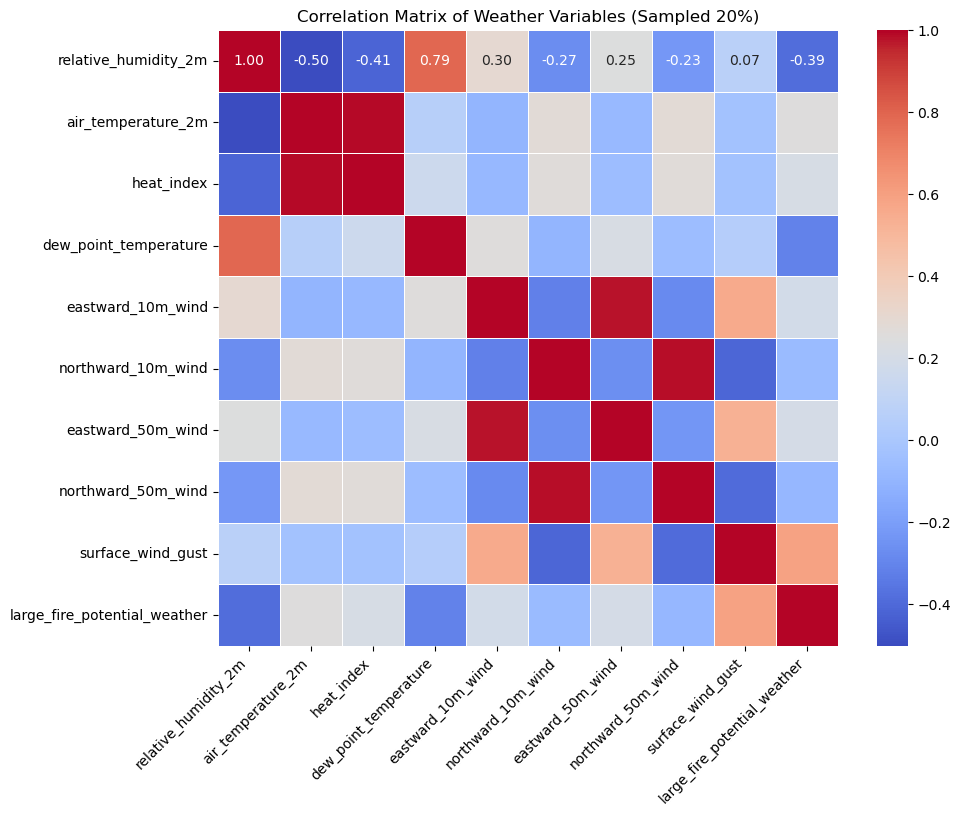

In [3]:
variables = ['relative_humidity_2m', 'air_temperature_2m', 'heat_index', 'dew_point_temperature', 
    'eastward_10m_wind', 'northward_10m_wind', 'eastward_50m_wind', 'northward_50m_wind',
    'surface_wind_gust', 'large_fire_potential_weather'
]


ds_selected = combined_ds[variables]

sample_fraction = 0.20  
total_points = ds_selected.dims['time']
sample_size = int(total_points * sample_fraction)

random_indices = np.random.choice(total_points, sample_size, replace=False)
ds_sampled = ds_selected.isel(time=random_indices) 

ds_sampled = ds_sampled.to_array(dim="variable")

ds_values = ds_sampled.data 
ds_flattened = ds_values.reshape(len(ds_sampled), -1)  
correlation_matrix = da.corrcoef(ds_flattened)  

corr_df = pd.DataFrame(correlation_matrix.compute(), index=variables, columns=variables)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0) 

plt.title("Correlation Matrix of Weather Variables (Sampled 20%)")
plt.show()

## 1.1 EDA with GPU

In [2]:
folder_path = "." 
batch_files = sorted([f for f in os.listdir(folder_path) if f.startswith("size_100_batch_") and f.endswith(".nc")])

print(f"Found {len(batch_files)} batch files.")
datasets = [xr.open_dataset(os.path.join(folder_path, file), chunks={}) for file in batch_files]
common_dims = set(datasets[0].dims)
for ds in datasets:
    common_dims.intersection_update(ds.dims)

exclude_dims = {"x", "y"}
valid_dims = [dim for dim in common_dims if dim not in exclude_dims]

if not valid_dims:
    raise ValueError("No common dimension found for concatenation!")

concat_dim = valid_dims[0]  
print(f"Using '{concat_dim}' as the concatenation dimension.")
combined_ds = xr.concat(datasets, dim=concat_dim)

print("\nAvailable columns (variables) in the dataset:")
print(list(combined_ds.variables))

Found 176 batch files.
Using 'time' as the concatenation dimension.

Available columns (variables) in the dataset:
['eastward_925mb_wind', 'northward_925mb_wind', 'eastward_850mb_wind', 'northward_850mb_wind', 'eastward_700mb_wind', 'northward_700mb_wind', 'eastward_500mb_wind', 'northward_500mb_wind', 'relative_humidity_pbl', 'relative_humidity_low_trop', 'relative_humidity_mid_trop', 'relative_humidity_925mb', 'relative_humidity_850mb', 'relative_humidity_700mb', 'total_precipitable_water', 'air_temperature_925mb', 'air_temperature_850mb', 'air_temperature_700mb', 'air_temperature_500mb', 'low_cloud_fraction', 'mid_cloud_fraction', 'high_cloud_fraction', 'cape_lifted_at_surface', 'cape_max_lifted_between_700mb_500mb', 'mucape', 'atmosphere_convective_inhibition_wrt_surface', 'atmosphere_convective_inhibition_700mb_500mb', 'lifted_index_from_surface', 'lifted_index_from_700mb', 'geopotential_height_at_925mb', 'geopotential_height_at_850mb', 'geopotential_height_at_700mb', 'geopotentia

In [3]:
variables = [
    'relative_humidity_pbl', 'relative_humidity_low_trop', 'relative_humidity_mid_trop', 
    'relative_humidity_2m', 'air_temperature_2m', 'heat_index', 'dew_point_temperature', 
    'eastward_10m_wind', 'northward_10m_wind', 'eastward_50m_wind', 'northward_50m_wind',
    'surface_wind_gust', 'large_fire_potential_weather'
]

ds_subset = combined_ds[variables]
df_dask = ds_subset.to_dask_dataframe()
df_dask = df_dask.dropna()
df_dask

,time,y,x,latitude,longitude,relative_humidity_pbl,relative_humidity_low_trop,relative_humidity_mid_trop,relative_humidity_2m,air_temperature_2m,heat_index,dew_point_temperature,eastward_10m_wind,northward_10m_wind,eastward_50m_wind,northward_50m_wind,surface_wind_gust,large_fire_potential_weather
npartitions=17520,,,,,,,,,,,,,,,,,,
0,datetime64[ns],int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
107920,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890650480,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890758399,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:

df_dask['wind_speed_10m'] = da.sqrt(df_dask['eastward_10m_wind']**2 + df_dask['northward_10m_wind']**2)
df_dask['wind_speed_50m'] = da.sqrt(df_dask['eastward_50m_wind']**2 + df_dask['northward_50m_wind']**2)

df_pandas = df_dask.compute()
df_pandas.head()

: 

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pandas['relative_humidity_2m'], y=df_pandas['large_fire_potential_weather'], alpha=0.5)
plt.xlabel('Relative Humidity at 2m (%)')
plt.ylabel('Large Fire Potential Weather')
plt.title('Humidity vs. Fire Potential')
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pandas['air_temperature_2m'], y=df_pandas['large_fire_potential_weather'], alpha=0.5, color='red')
plt.xlabel('Air Temperature at 2m (K)')
plt.ylabel('Large Fire Potential Weather')
plt.title('Temperature vs. Fire Potential')
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pandas['wind_speed_10m'], y=df_pandas['large_fire_potential_weather'], alpha=0.5, color='green')
plt.xlabel('Wind Speed at 10m (m/s)')
plt.ylabel('Large Fire Potential Weather')
plt.title('Wind Speed vs. Fire Potential')
plt.show()



In [ ]:
correlation_matrix = df_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.show()

In [ ]:
target_corr = correlation_matrix['large_fire_potential_weather'].abs().sort_values(ascending=False)
print("\nTop correlated features with 'large_fire_potential_weather':")
print(target_corr.head(10))